## Importing Packages

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


## Loading CIFAR10 dataset

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
print(num_classes)

10


## Dataset Exploration

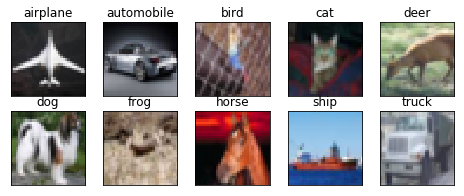

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Utility functions

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Dataset Pre-processing

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Base score - 83.55

## Creating model

This models is built based on the below architecture:
  1. Normal Convolution
  2. Spatially Separable Convolution  (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))
  3. Depthwise Separable Convolution
  4. Grouped Convolution (use 3x3, 5x5 only)
  5. Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 
  
This model is built on Keras Functional API. Here, Spatially and Depthwise seperable convolutions have been used to reduce the computation complexity while retaining the spatial informations. Both Spatial and depthwise convolution have been used in thier raw form or combined two seperate convolutions to perform seperable convolution. 

Later I have applied grouped convolutions to carry forward the different receptive fields to the prediction layer. in order to concatenate layers in grouped convolution, the **border_mode** has kept as *\"same\"*. There are other efficient ways to append and we will utilize those functionalities in the coming solutions.


In [8]:
# Define the model

input = Input(shape=(32,32,3))

#  Normal Convolution
conv1= Convolution2D(32,3,3, border_mode='same')(input)
conv1= Activation('relu')(conv1)
conv1= BatchNormalization()(conv1)
conv1= Dropout(0.2)(conv1)

conv2= Convolution2D(64,3,3)(conv1)
conv2= Activation('relu')(conv2)
conv2= BatchNormalization()(conv2)
conv2= Dropout(0.2)(conv2)

conv3= Convolution2D(128,3,3)(conv2)
conv3= Activation('relu')(conv3)
conv3= BatchNormalization()(conv3)
conv3= Dropout(0.2)(conv3)

maxpool1= MaxPooling2D(pool_size=(2, 2))(conv3)
maxpool1= Dropout(0.2)(maxpool1)

#Spatially Seperable convolution (1x3 | 3x1)

ssconv4= Convolution2D(64,3,1)(maxpool1)
ssconv4= Activation('relu')(ssconv4)
ssconv4= BatchNormalization()(ssconv4)
ssconv4= Dropout(0.2)(ssconv4)

ssconv5= Convolution2D(128,1,3)(ssconv4)
ssconv5= Activation('relu')(ssconv5)
ssconv5= BatchNormalization()(ssconv5)
ssconv5= Dropout(0.2)(ssconv5)

# Normal Convolution
conv6= Convolution2D(256,3,3)(ssconv5)
conv6= Activation('relu')(conv6)
conv6= BatchNormalization()(conv6)
conv6= Dropout(0.2)(conv6)

maxpool2= MaxPooling2D(pool_size=(2, 2))(conv6)
maxpool2= Dropout(0.2)(maxpool2)

# Depthwise Seperable Convolution (3x3 | 1x1)
dsconv7= Convolution2D(128,3,3)(maxpool2)
dsconv7= Activation('relu')(dsconv7)
dsconv7= BatchNormalization()(dsconv7)
dsconv7= Dropout(0.2)(dsconv7)

dsconv8= Convolution2D(256,1,1)(dsconv7)
dsconv8= Activation('relu')(dsconv8)
dsconv8= BatchNormalization()(dsconv8)
dsconv8= Dropout(0.2)(dsconv8)

# Grouped Convolution (3x3 + 5x5)  
conv9_1= Convolution2D(256,3,3, border_mode='same')(dsconv8) # output size- 3x3 ; receptive field - 34x34
conv9_1= Activation('relu')(conv9_1)
conv9_1= BatchNormalization()(conv9_1)
conv9_1= Dropout(0.2)(conv9_1)

conv9_2= Convolution2D(256,5,5, border_mode='same')(dsconv8) # output size- 3x3 ; receptive field - 42x42
conv9_2= Activation('relu')(conv9_2)
conv9_2= BatchNormalization()(conv9_2)
conv9_2= Dropout(0.2)(conv9_2)

grouped_conv9= Concatenate()([conv9_1, conv9_2]) # receptive field - 34, 42

# Groupe Convolution (Dilation-1 + Dilation-2)

conv10_1= Convolution2D(256,3,3, dilation_rate=(1,1), border_mode='same')(grouped_conv9) # receptive field - 42, 50
conv10_1= Activation('relu')(conv10_1)
conv10_1= BatchNormalization()(conv10_1)
conv10_1= Dropout(0.2)(conv10_1)

conv10_2= Convolution2D(256,5,5, dilation_rate=(2,2), border_mode='same')(grouped_conv9) # receptive field - 50, 58
conv10_2= Activation('relu')(conv10_2)
conv10_2= BatchNormalization()(conv10_2)
conv10_2= Dropout(0.2)(conv10_2)

grouped_conv10= Concatenate()([conv10_1, conv10_2]) # receptive field - 34, 42, 50, 58


# Normal Conolution
conv11= Convolution2D(10,3,3)(grouped_conv10) # receptive field - 34, 42, 50, 58, 66
conv11= Activation('relu')(conv11)
conv11= BatchNormalization()(conv11)
conv11= Dropout(0.2)(conv11)


# Pointwise Convolution 
conv12= Convolution2D(10,1)(conv11) # Output size - 1x1 ; receptive field - 34, 42, 50, 58, 66
conv12= Activation('relu')(conv12)

output= Flatten()(conv12)
output= Activation('softmax')(output)

model=Model(inputs= input, outputs=output)

W0615 19:06:12.340087 139855875323776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0615 19:06:12.374241 139855875323776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
  after removing the cwd from sys.path.
W0615 19:06:12.381409 139855875323776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0615 19:06:12.417320 139855875323776 deprecation_wrapper.py:119] From /usr/local/li

In [9]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
  return round(0.003*1/(1+.319*epoch),10)

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.003),
             metrics=['accuracy'])
model.summary()

W0615 19:06:16.412488 139855875323776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         activation_1[0][0]               
__________________________________________________________________________________________________
dropout_1 

## Training the model

I have using learning rate schedular to reulate the learning rate in rder to reduce the fuctaltions in the accuracy graph.

### Observations:
- Overfitting
- No significant improvements after 27th epoch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=195, epochs=50)`
  
W0615 19:06:16.715083 139855875323776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a 

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
195/195 [==============================] - 44s 225ms/step - loss: 1.7770 - acc: 0.3771 - val_loss: 2.2359 - val_acc: 0.3642
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
195/195 [==============================] - 36s 186ms/step - loss: 1.2483 - acc: 0.5740 - val_loss: 1.4126 - val_acc: 0.5637
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
195/195 [==============================] - 35s 181ms/step - loss: 0.9983 - acc: 0.6656 - val_loss: 1.1007 - val_acc: 0.6449
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
195/195 [==============================] - 35s 180ms/step - loss: 0.8623 - acc: 0.7150 - val_loss: 1.2681 - val_acc: 0.6089
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
195/195 [==============================] - 35s 179ms/step - loss: 0.7612 - acc: 0

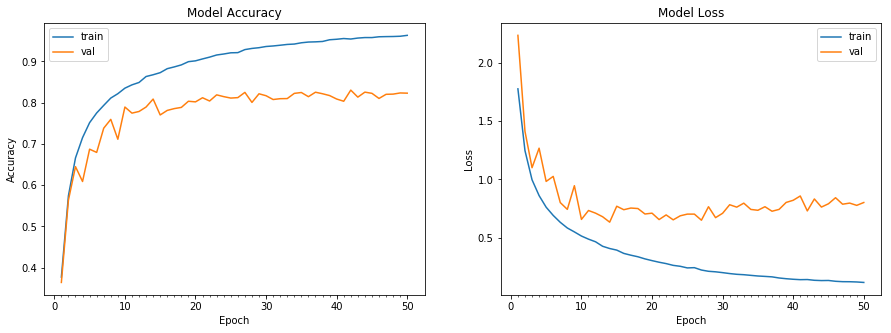

Accuracy on test data is: 82.30


In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), 
                                 callbacks=[LearningRateScheduler(scheduler,verbose=1)],
                                 verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))